# Overview

This is a step by step demonstration of the composite BM3D filtering algorithm described in the Makinen_etal_2020 paper.

## Prepare example input

We will be using real experiment data (for integration test) in this notebook.

In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

In [2]:
this_dir = os.path.abspath("")
data_dir = os.path.join(this_dir, "../tests/bm3dornl-data")
datafile = os.path.join(data_dir, "tomostack_small.h5")

with h5py.File(datafile, "r") as f:
    tomo_noisy = f["noisy_tomostack"][:]
    tomo_bm3d_ref = f["clean_tomostack"][:]

In [3]:
print(tomo_noisy.shape)

(591, 540, 620)


We will pick one example with lots of vertical streak, feel free to switch to others when running by yourself.

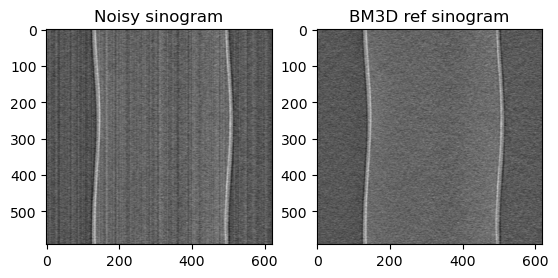

In [4]:
sino_noisy = tomo_noisy[:, 10, :]
sino_bm3d_ref = tomo_bm3d_ref[:, 10, :]

# visualize side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sino_noisy, cmap="gray")
ax[0].set_title("Noisy sinogram")
ax[1].imshow(sino_bm3d_ref, cmap="gray")
ax[1].set_title("BM3D ref sinogram")
plt.show()

## BM3D step by step

In [5]:
from bm3dornl.noise_analysis import (
    estimate_noise_psd,
    get_exact_noise_variance,
)
from bm3dornl.block_matching import (
    get_patch_numba,
    get_signal_patch_positions,
)
from bm3dornl.signal import (
    fft_transform,
)
from bm3dornl.bm3d import (
    shrinkage_via_hardthresholding,
    global_fourier_thresholding,
    collaborative_filtering,
)
from bm3dornl.denoiser_gpu import (
    shrinkage_fft,
    collaborative_wiener_filtering,
)

In [6]:
# Define parameters
patch_size = (8, 8)
stride = 3
background_threshold = 0.0  # assume we don't know the background level
num_patches_per_group = 64
padding_mode = "circular"
cut_off_distance = (128, 128)
shrinkage_factor = 3.0

preprocess sinogram

In [7]:
# record the original dynamic range
original_max = np.max(sino_noisy)
original_min = np.min(sino_noisy)

# create input (z) and corresponding PSD (phi)
z = (sino_noisy - original_min) / (original_max - original_min)
phi = estimate_noise_psd(z)

### Step 1

The first step is to use hard thresholding to get a pilot noise free estimate:

$$ HT(z, \Phi) \rightarrow \hat{y}_{ht} $$

In [8]:
# get the patch positions
# note: we can resuse this for later stages as well
patch_positions = get_signal_patch_positions(
    image=z,
    patch_size=patch_size,
    stride=stride,
    background_threshold=background_threshold,
)
# retrieve all patches (need the actual signals)
signal_patches = np.array(
    [get_patch_numba(z, pos, patch_size) for pos in patch_positions]
)
# transform the patches to the frequency domain (use fft here for simplicity)
signal_patches_fft = fft_transform(signal_patches)
# estimate the noise variance for the transformed patch
phi_fft = get_exact_noise_variance(signal_patches_fft)
# commence hard-thresholding
yhat_ht = shrinkage_via_hardthresholding(
    sinogram=z,
    patch_size=patch_size,
    num_patches_per_group=num_patches_per_group,
    padding_mode=padding_mode,
    transformed_patches=signal_patches_fft,
    noise_variance=phi_fft,
    patch_positions=patch_positions,
    cut_off_distance=cut_off_distance,
    shrinkage_factor=shrinkage_factor,
    shrinkage_func=shrinkage_fft,
)

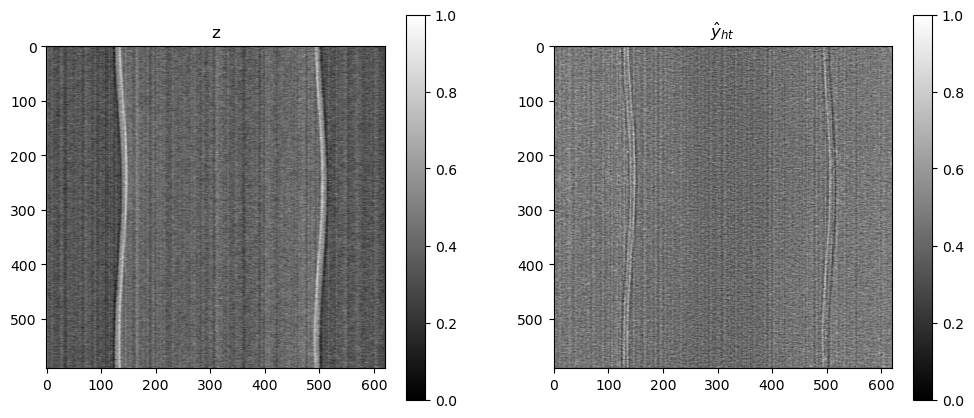

In [9]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(yhat_ht, cmap="gray")
plt.title("$\hat{y}_{ht}$")
plt.colorbar()
plt.show()

### Step 2

The second step is to do a global refiltering to get another **noisy** image, that will serve as the new base for the next hard-thresholding, i.e.

$$ GFT(z, \Phi, \hat{y}_{ht}) \rightarrow z^{GFT}_{ht} $$

In [10]:
z_gft_ht = global_fourier_thresholding(z, phi, yhat_ht)

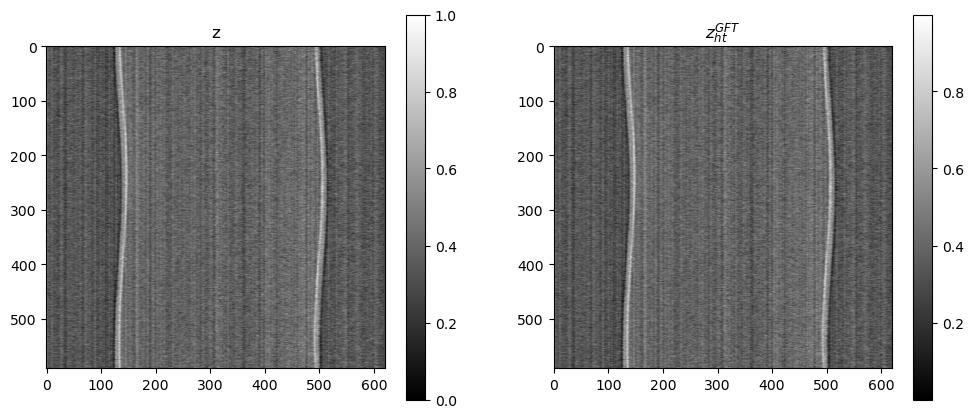

In [11]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(z_gft_ht, cmap="gray")
plt.title("$z^{GFT}_{ht}$")
plt.colorbar()
plt.show()

### Step 3

Now we will use one more hard-thresholding to get the actual pilot noise free estimate, i.e.

$$ HT(z^{GFT}_{ht}, \Phi^{GFT}_{ht}, \hat{y}_{ht}) \rightarrow \hat{y}_{ht}^{GFT} $$

In [12]:
# retrieve patches from z_gft_ht
signal_patches = np.array(
    [get_patch_numba(z_gft_ht, pos, patch_size) for pos in patch_positions]
)
# compute the transformed patches
signal_patches_fft = fft_transform(signal_patches)
# estimate the noise variance for the transformed patch
phi_fft_gft_ht = get_exact_noise_variance(signal_patches_fft)
# commence hard-thresholding
yhat_ht_gft = shrinkage_via_hardthresholding(
    sinogram=z_gft_ht,
    patch_size=patch_size,
    num_patches_per_group=num_patches_per_group,
    padding_mode=padding_mode,
    transformed_patches=signal_patches_fft,
    noise_variance=phi_fft_gft_ht,
    patch_positions=patch_positions,
    cut_off_distance=cut_off_distance,
    shrinkage_factor=shrinkage_factor,
    shrinkage_func=shrinkage_fft,
)

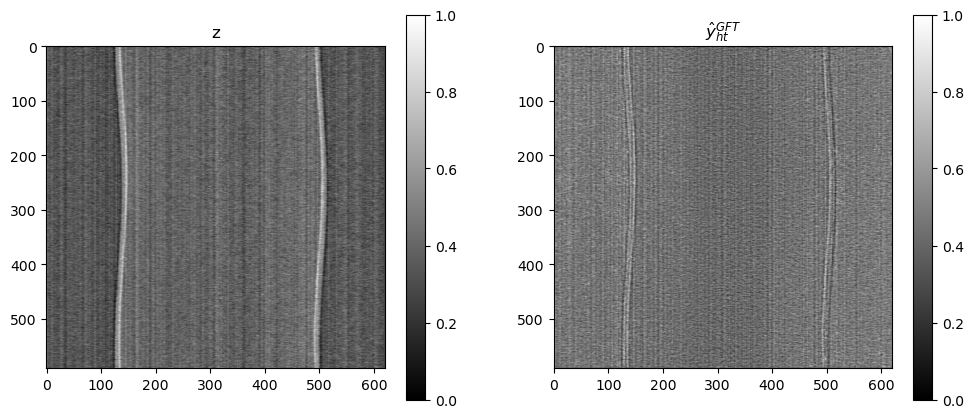

In [13]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(yhat_ht_gft, cmap="gray")
plt.title("$\hat{y}^{GFT}_{ht}$")
plt.colorbar()
plt.show()

now $\hat{y}^{GFT}_{ht}$ is our noise free estimate, referred to as pilot estimate in the paper.

## Step 4

Now we are going to use the pilot estimate and wiener filtering to get a good initial denoised results, i.e.

$$ WIE(z, \Phi, \hat{y}^{GFT}_{ht}) \rightarrow \hat{y}_{wie} $$

In [14]:
yhat_wie = collaborative_filtering(
    sinogram=z,
    denoised_sinogram=yhat_ht_gft,
    patch_size=patch_size,
    num_patches_per_group=num_patches_per_group,
    padding_mode=padding_mode,
    noise_variance=phi_fft,
    patch_positions=patch_positions,
    cut_off_distance=cut_off_distance,
    transform_func=fft_transform,
    collaborative_filtering_func=collaborative_wiener_filtering,
)

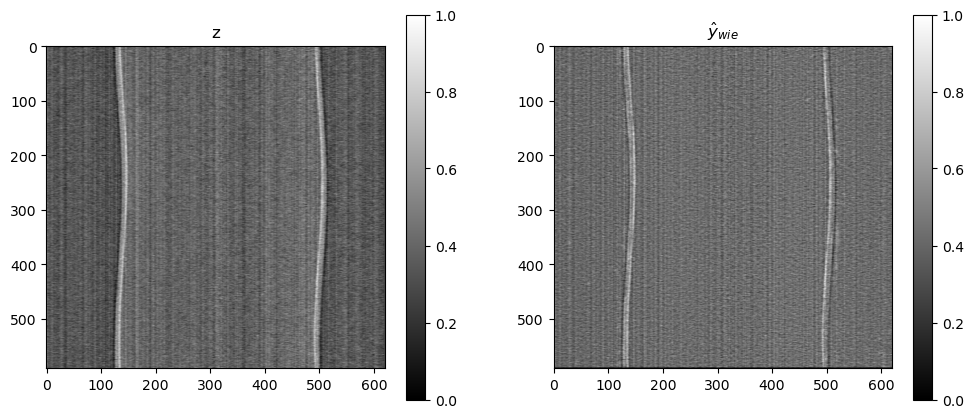

In [15]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(yhat_wie, cmap="gray")
plt.title("$\hat{y}_{wie}$")
plt.colorbar()
plt.show()

### Step 5:

Now we will use the global thresholding again to get a **noisy** image as the base for the next and final wiener filtering, i.e.

$$ GFT(z, \Phi, \hat{y}_{wie}) \rightarrow z^{GFT}_{wie} $$

In [16]:
z_gft_wie = global_fourier_thresholding(z, phi, yhat_wie)

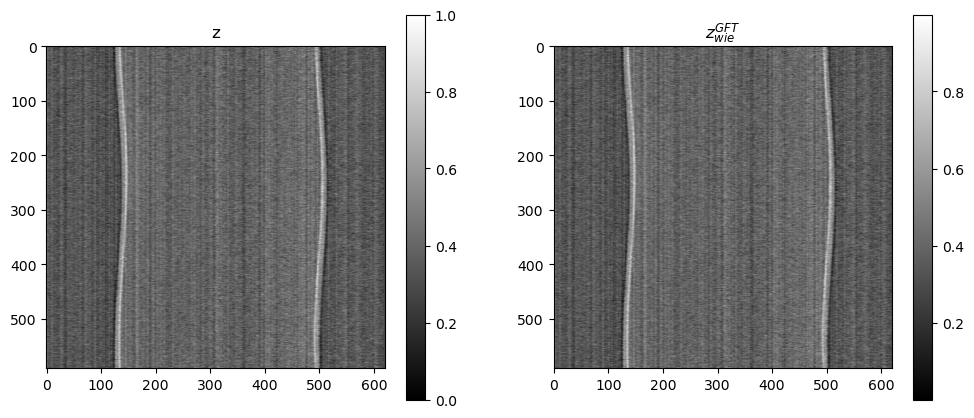

In [17]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(z_gft_wie, cmap="gray")
plt.title("$z^{GFT}_{wie}$")
plt.colorbar()
plt.show()

### Step 6

Now the final step, use the constructed new noisy image, $z^{GFT}_{wie}$ as base and the refined pilot estimate, $\hat{y}_{wie}$ as signal reference to do the final wiener filtering, i.e.

$$ WIE(z^{GFT}_{wie}, \Phi^{GFT}_{wie}, \hat{y}_{wie}) \rightarrow \hat{y}_{final} $$

In [18]:
# first thing first, we need to compute PSD for the new noisy sinogram
signal_patches = np.array(
    [get_patch_numba(z_gft_wie, pos, patch_size) for pos in patch_positions]
)
signal_patches_fft = fft_transform(signal_patches)
phi_fft_gft_wie = get_exact_noise_variance(signal_patches_fft)
# commence wiener filtering
yhat_final = collaborative_filtering(
    sinogram=z_gft_wie,
    denoised_sinogram=yhat_wie,
    patch_size=patch_size,
    num_patches_per_group=num_patches_per_group,
    padding_mode=padding_mode,
    noise_variance=phi_fft_gft_wie,
    patch_positions=patch_positions,
    cut_off_distance=cut_off_distance,
    transform_func=fft_transform,
    collaborative_filtering_func=collaborative_wiener_filtering,
)

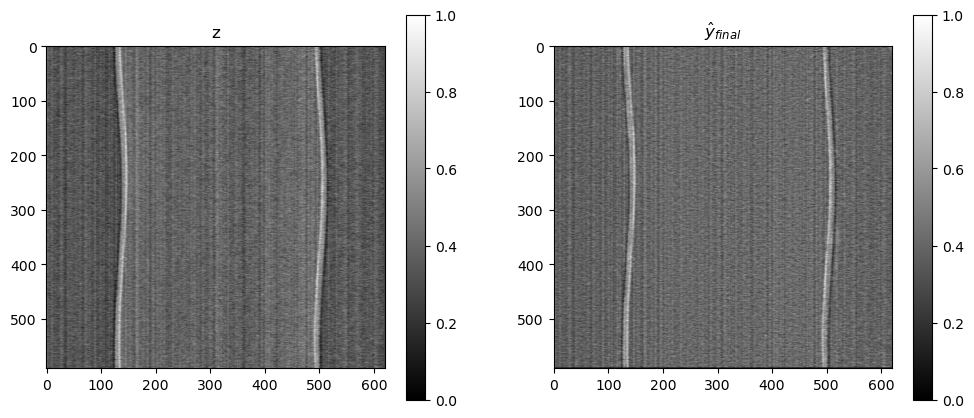

In [19]:
# quick visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="gray")
plt.title("z")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(yhat_final, cmap="gray")
plt.title("$\hat{y}_{final}$")
plt.colorbar()
plt.show()

finally step, rescale to match the original image intensity range.

In [20]:
# rescale the final denoised sinogram to [0, 1]
yhat_final = (yhat_final - np.min(yhat_final)) / (
    np.max(yhat_final) - np.min(yhat_final)
)
# rescale the final denoised sinogram to the original dynamic range
sino_denoised = yhat_final * (original_max - original_min) + original_min

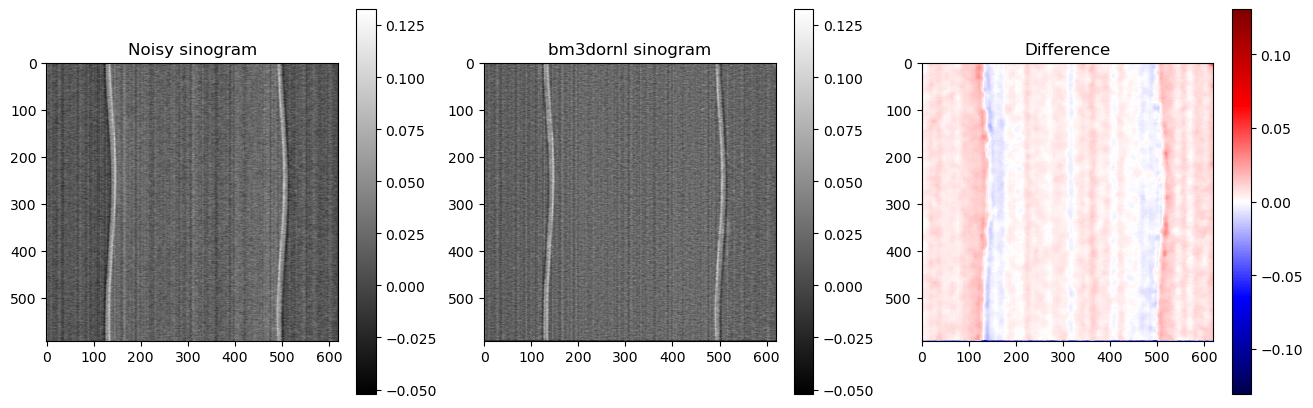

In [21]:
# visualize side by side
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(sino_noisy, cmap="gray")
plt.title("Noisy sinogram")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(sino_denoised, cmap="gray")
plt.title("bm3dornl sinogram")
plt.colorbar()
plt.subplot(1, 3, 3)
diff = sino_denoised - sino_noisy
cval = np.max(np.abs(diff))
plt.imshow(diff, cmap="seismic", vmin=-cval, vmax=cval)
plt.title("Difference")
plt.colorbar()
plt.show()

The results here is not as good as the reference for the following reasons:

- additional parameter tuning is needed, especially for the hard thresholding part where the shrinkage factor can have a significant impact on the pilot estimate, which will affect the final result.
- the reference is generated using multi-scale denoising that described in a following-up paper (2021), so it is more refined for strong vertical artifacts like the one in the example.